# Esercitazione 5 - Campionamento di alcune funzioni d'onda dell'atomo di idrogeno con l'algoritmo di Metropolis

## Obiettivo

L'obiettivo dell'esercitazione è l'applicazione dell'algoritmo di Metropolis per il campionamento delle distribuzioni di probabilità ottenute dalle funzioni d'onda dell'atomo di idrogeno. I punti campionati vengono poi utilizzati per stimare il valore aspettato $\langle r \rangle$ della distanza dell'elettrone dal nucleo.

Questo calcolo viene effettuato per le configurazioni 1s e 2p.

## Cenni teorici e metodi utilizzati

Le distribuzioni di probabilità da campionare sono ottenute dal modulo quadro delle rispettive funzioni d'onda dei due stati. Le loro espressioni sono le seguenti:
$$
|\Psi_{1,0,0}(r,\theta,\phi)|^2=
\frac{a_0^{-3}}{\pi} e^{-2r/a_0} 
$$

$$
|\Psi_{2,1,0}(r,\theta,\phi)|^2=
\frac{a_0^{-5}}{32}\frac{1}{\pi} r^2 e^{-r/a_0} \cos^2(\theta)
$$
dove $a_0=4\pi\epsilon_0\hbar^2/m_e e^2=0.0529$ nm è il raggio di Bohr.

Per il campionamento viene utilizzato l'algoritmo di Metropolis. Ciascuno step del'algoritmo produce il campionamento di un punto e consiste nell'esecuzione dei seguenti passaggi:
- dal punto $\vec r_i$ dello spazio da campionare (in questo caso $\mathbb R^3$) viene proposta una mossa, ovvero il passaggio ad un altro punto $\vec r_{i+1}$ estratto con distribuzione di probabilità pari alla funzione di transizione $T(\vec r_i| \vec r_{i+1})$. È quindi necessario saper campionare T con altri metodi.
- si decide quindi se accettare o rigettare il passaggio al punto $\vec r_{i+1}$ riproducendo una probabiilità di accettazione pari a $A(\vec r_{i+1}| \vec r_{i}) = \text{min}[1, q(\vec r_{i+1}| \vec r_{i})]$ con
$$
q(\vec r_{i+1}| \vec r_{i}) = \frac{T(\vec r_i| \vec r_{i+1})p(\vec r_{i+1})}{T(\vec r_{i+1}| \vec r_{i})p(\vec r_{i})}
$$
Dove $p(\vec r)$ è la distribuzione di probabilità che si vuole campionare.
Nel caso la funzione di transizione sia simmetrica nei suoi due argomenti, quest'ultima espressione si semplifica in
$$
q(\vec r_{i+1}| \vec r_{i}) = \frac{p(\vec r_{i+1})}{p(\vec r_{i})}
$$
- se il punto $\vec r_{i+1}$ viene accettato allora sarà il nuovo punto campionato. Se invece viene rifiutato, lo stesso punto precedente $r_i$ viene considerato un nuovo punto del campionamento.
- si riparte quindi con gli stessi passaggi ma dal nuovo punto $\vec r_{i+1}$

Si può dimostrare che l'algoritmo di Metropolis realizza il campionamento della distribuzione di probabilità $p(\vec r)$ asintoticamente. È quindi necessario effettuare una fase iniziale di equilibrazione, consistente nell'esecuzione di alcuni step "a vuoto", atta a raggiungere la convergenza allo stato asintotico.

L'implementazione dell'algoritmo di Metropolis lascia aperte alcune scelte progettuali, tra cui:
- la scelta del punto da cui iniziare il campionamento
- la scelta della funzione di transizione e dei parametri che la caratterizzano

Nei paragrafi successivi verranno discusse le scelte fatte nella risoluzione di questo esercizio.

## Implementazione

Ho implementato l'algoritmo di Metropolis utilizzando due diverse funzioni di transizione. Nella prima parte dell'esercizio utilizzo una funzione di transizione uniforme 

$$
T(\vec{x}|\vec{y}) = \cases{1/a^3, \hspace{10pt} |x_1 - y_1| < a/2 \land |x_2 - y_2| < a/2 \land |x_3 - y_3| < a/2 \\
0, \hspace{10pt} \text{otherwise}}
$$

Si può notare la presenza di un parametro libero $a$ che verrà opportunamente scelto.

Ho poi anche implementato la possibilità di utilizzare come funzione di transizione la distribuzione normale multivariata, consistente in una distribuzione gaussiana per ciascuna coordinata. In questo caso il parametro libero $a$ rappresenta la deviazione standard.

Entrambe queste funzioni di transizione sono simmetriche.

Il codice realizzato utilizza istanze delle classi virtuali `TransitionProbability` e `ProbabilityDist` opportunamente specializzate per risolvere i problemi oggetto dell'esercitazione. Tuttavia è possibile implementare nuove specializzazioni di queste classi e riutilizzare lo stesso codice per effettuare nuovi campionamenti. In questo modo è possibile provare, ad esempio, ad utilizzare diverse funzioni di transizione o campionare distribuzioni di probabilità ottenute da funzioni d'onda differenti.

I punti campionati vengono utilizzati per il calcolo, tramite l'algoritmo della media a blocchi, del valor aspettato di $\vec r$, ovvero la distanza media dell'elettrone dal nucleo. Tutte le lunghezze sono espresse in unità di $a_0$. L'algoritmo della media a blocchi permette di calcolare le incertezze ed eliminare possibili errori sistematici dovuti alla correlazione tra punti consecutivi.

Prima di iniziare a campionare i valori viene eseguita una fase di equilibrazione.

## Utilizzo

I parametri riguardanti il numero delle varie iterazioni (step Monte Carlo, blocchi, ...) possono essere impostati modificando la definizione di alcune costanti.

Il programma realizzato può essere eseguito con una serie di argomenti che permettono di specificare la funzione di transizione da utilizzare tra quelle proposte, la distribuzione di probabilità da campionare e il nome del file in cui salvare i valori di $\langle r \rangle$ ottenuti. È possibile anche utilizzare due argomenti opzionali che permettono di salvare su file le coordinate di un certo numero di punti campionati.

Il file contenente gli $\langle r \rangle$ è organizzato in righe riferite ciascuna ad un diverso blocco, esse contengono in quest'ordine:
- la miglior stima di $\langle r \rangle$ al blocco corrispondente alla riga
- l'incertezza statistica sul valore precedente

I file nei quali vengono salvati i punti contengono invece, per ogni riga, le 3 coordinate di un diverso punto campionato.

## Regolazione del tasso di accettazione

I parametri liberi $a$ delle due funzioni di transizione sono stati scelti in modo da ottenere un tasso di accettazione prossimo al 50\% per entrambe le distribuzioni di probabilità da campionare. Infatti, un tasso di accettazione troppo alto provocherebbe una forte correlazione tra punti successivi e una maggiore difficoltà nel campionare l'intero spazio. D'altra parte un tasso di accettazione troppo basso renderebbe eccessivamente inefficiente il campionamento. La scelta dei parametri in modo tale da ottenere un valore prossimo al 50\% permette di bilanciare questi effetti.

Per effettuare questa scelta, ho implementato all'interno dello stesso codice una modalità alternativa con cui avviare il programma che esegue una serie di campionamenti variando il parametro a e registrando i diversi tassi di accettazione ottenuti. Ciascun tasso di accettazione viene valutato sul campionamento di $10^6$ punti.

Nei grafici seguenti è possibile apprezzare la dipendenza del tasso di accettazione dal parametro $a$ nel campionamento sia della configurazione 1s sia della configurazione 2p e per entrambe le funzioni di transizione. Da questi grafici sono stati estrapolati i valori poi utilizzati nelle successive simulazioni.
Sono stati scelti valori differenti per ciascuna configurazione. Infatti, come si può osservare dai grafici, la diversa localizzazione spaziale delle due distribuzioni di probabilità provoca, a parità di $a$, tassi di accettazione significativamente diversi.

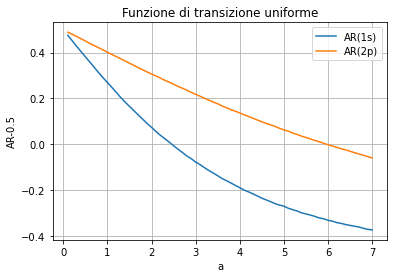

La migliore scelta per il parametro nelle due configurazioni è:
- configurazione 1s >> r = 2.5
- configurazione 2p >> r = 6.0


In [1]:
from IPython.display import display, Latex
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

ru, au1, au2 = np.loadtxt('../05/val_r_uni.out', usecols=(0,1,2), delimiter=" ", unpack=True)
plt.plot(ru, au1-0.5, label='AR(1s)')
plt.plot(ru, au2-0.5, label='AR(2p)')

plt.xlabel('a')
plt.ylabel('AR-0.5')
plt.legend()
plt.title('Funzione di transizione uniforme')
plt.grid()
plt.show()

a_1s = ru[np.abs(au1-0.5).argmin()]
a_2p = ru[np.abs(au2-0.5).argmin()]
print("La migliore scelta per il parametro nelle due configurazioni è:")
print("- configurazione 1s >> r = {:.1f}".format(a_1s))
print("- configurazione 2p >> r = {:.1f}".format(a_2p))

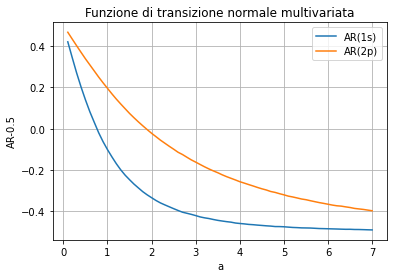

La migliore scelta per il parametro nelle due configurazioni è:
- configurazione 1s >> s = 0.8
- configurazione 2p >> s = 1.9


In [2]:
ru, au1, au2 = np.loadtxt('../05/val_r_gauss.out', usecols=(0,1,2), delimiter=" ", unpack=True)
plt.plot(ru, au1-0.5, label='AR(1s)')
plt.plot(ru, au2-0.5, label='AR(2p)')
plt.xlabel('a')
plt.ylabel('AR-0.5')
plt.legend()
plt.title('Funzione di transizione normale multivariata')
plt.grid()
plt.show()

a_1s = ru[np.abs(au1-0.5).argmin()]
a_2p = ru[np.abs(au2-0.5).argmin()]
print("La migliore scelta per il parametro nelle due configurazioni è:")
print("- configurazione 1s >> s = {:.1f}".format(a_1s))
print("- configurazione 2p >> s = {:.1f}".format(a_2p))

## Scelta del punto di partenza per il campionamento

Diversi tentativi mi hanno permesso di verificare che la convergenza alla condizione asintotica, in cui l'algoritmo riproduce la distribuzione di probabilità desiderata, è raggiunta più velocemente se il punto di partenza viene scelto in una regione in cui tale distribuzione di probabilità è significativamente diversa da zero.
Entrambe le distribuzioni considerate sono significativamente diverse da zero in una regione delle dimensioni di qualche $a_0$ intorno all'origine. 
Iniziando a campionare da un punto distante qualche centinaio di $a_0$ dall'origine si può osservare come l'algoritmo fatichi o addirittura fallisca nella convergenza.

In seguito è mostrato un esempio dei punti campionati partendo dal punto (1000, 1000, 1000)$a_0$ dopo 100 estrazioni effettuate "a vuoto" come equilibrazione

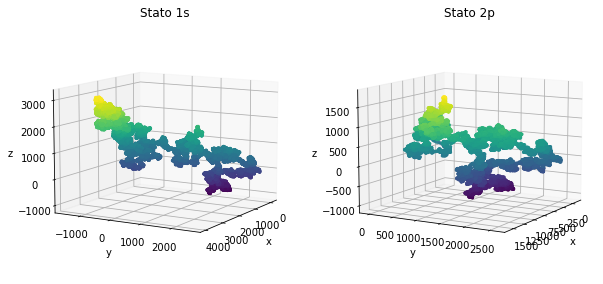

In [3]:
fig = plt.figure(figsize=[10,5])

x, y, z = np.loadtxt('../05/points1SFAR', usecols=(0,1,2), delimiter=" ", unpack=True)
ax1s = fig.add_subplot(1, 2, 1, projection='3d', label='1s')
ax1s.scatter(x, y, z, c=z, marker='.')
ax1s.set_xlabel('x')
ax1s.set_ylabel('y')
ax1s.set_zlabel('z')
ax1s.set_title('Stato 1s')
ax1s.view_init(10, 30)

x, y, z = np.loadtxt('../05/points2PFAR', usecols=(0,1,2), delimiter=" ", unpack=True)
ax2p = fig.add_subplot(1, 2, 2, projection='3d', label='2p')
ax2p.scatter(x, y, z, c=z, marker='.')
ax2p.set_xlabel('x')
ax2p.set_ylabel('y')
ax2p.set_zlabel('z')
ax2p.set_title('Stato 2p')
ax2p.view_init(10, 30)

plt.show()

Comparando questi grafici con quelli nei paragrafi successivi si può chiaramente osservare il fallimento dell'algoritmo nel riprodurre la distribuzione di probabilità aspettata. Questa simulazione è stata realizzata utilizzando la funzione di transizione uniforme. La funzione di transizione normale multivariata fornisce risultati analoghi.

## Risultati ottenuti con funzione di transizione uniforme

### Configurazione 1s
In questa simulazione ho utilizzato l'algoritmo di Metropolis per campionare la distribuzione di probabilità data dal modulo quadro dell'autofunzione 1s dell'atomo di idrogeno 

$$
\Psi_{1,0,0}(r,\theta,\phi)=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0} 
$$

la simulazione viene eseguita utilizzando $a_0 = 1$ e i valori di $\langle r \rangle$ ottenuti sono dunque in unità di $a_0$.
Il valore aspettato dai calcoli analitici è
$$
\left\langle r \right\rangle_{\Psi_{1,0,0}} = \frac{3}{2}a_0
\quad
$$
per questa simulazione ho eseguito $10^7$ estrazioni suddivise in 100 blocchi. Prima di utilizzare i valori estratti con l'algoritmo di Metropolis per le misure, ho eseguito 100 estrazioni "a vuoto" al fine di raggiungere la condizione di convergenza desiderata.

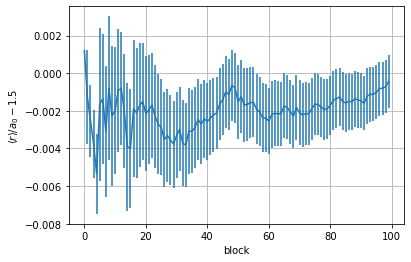

stima finale di <r>: 1.500 a_0
incertezza: 0.001 a_0

distante 0.3σ dal valore aspettato


In [4]:
r, err = np.loadtxt('../05/uni1s_bm.out', usecols=(0,1), delimiter=" ", unpack=True)
x = np.arange(0, len(r))
plt.errorbar(x, r-1.5, err)
plt.xlabel("block")
plt.ylabel('$\\langle r \\rangle /a_0 -1.5$')

plt.grid()
plt.show()

print("stima finale di <r>: {:.3f} a_0".format(r[-1]))
print("incertezza: {:.1} a_0".format(err[-1]))
print('\ndistante {:.1}σ dal valore aspettato'.format(abs(r[-1]-1.5)/err[-1]))

Il grafico mostra, in funzione del numero di blocchi considerati, la migliore stima di $\langle r \rangle$ ottenuta durante la simulazione. Si osserva al crescere del numero di blocchi l'aumento dell'accuratezza del risultato e la diminuzione dell'incertezza statistica. Il risultato ottenuto risulta quindi compatibile con quello calcolato analiticamente.

### Configurazione 2p
in questa simulazione ho invece campionato la distribuzione di probabilità ottenuta dal modulo quadro dell'autofunzione 2p dell'atomo di idrogeno

$$
\Psi_{2,1,0}(r,\theta,\phi)=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta)
$$

anche in questo caso il risultato di $\langle r \rangle$ ottenuto si intende espresso in unità di $a_0$, il risultato aspettato dai calcoli analitici è 
$$
\left\langle r \right\rangle_{\Psi_{2,1,0}} = 5 a_0
$$
Il numero di step e blocchi utilizzati è lo stesso della simulazione precedente.


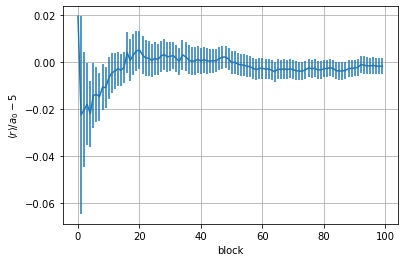

stima finale di <r>: 4.998 a_0
incertezza: 0.003 a_0

distante 0.5σ dal valore aspettato


In [6]:
r, err = np.loadtxt('../05/uni2p_bm.out', usecols=(0,1), delimiter=" ", unpack=True)
x = np.arange(0, len(r))
plt.errorbar(x, r-5, err)
plt.xlabel("block")
plt.ylabel('$\\langle r \\rangle /a_0 -5$')
plt.grid()
plt.show()

print("stima finale di <r>: {:.4} a_0".format(r[-1]))
print("incertezza: {:.1} a_0".format(err[-1]))
print('\ndistante {:.1}σ dal valore aspettato'.format(abs(r[-1]-5)/err[-1]))

Anche in questo caso il risultato ottenuto risulta compatibile con quello ottenibile dai calcoli analitici.

## Risultati ottenuti con una distribuzione normale multivariata come funzione di transizione

In questa parte dell'esercizio ho eseguito le stesse simulazioni utilizzando come funzione di transizione $T(\vec{x}|\vec{y})$ una distribuzione normale multivariata centrata in $\vec{y}$. 
Il parametro di questa distribuzione è la deviazione standard delle gaussiane con cui è realizzata, i valori scelti sono già stati discussi. Ho eseguito simulazioni con numeri di steps e blocchi analoghi a quelli precedenti. 
I risultati ottenuti sono i seguenti

### Configurazione 1s

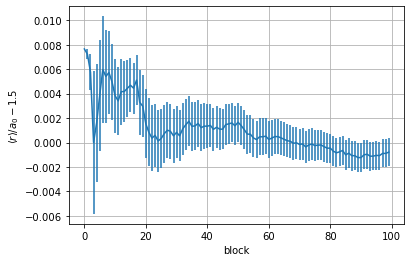

stima finale di <r>: 1.499 a_0
incertezza: 0.001 a_0

distante 0.7σ dal valore aspettato


In [7]:
r, err = np.loadtxt('../05/gauss1s_bm.out', usecols=(0,1), delimiter=" ", unpack=True)
x = np.arange(0, len(r))
plt.errorbar(x, r-1.5, err)
plt.xlabel("block")
plt.ylabel('$\\langle r \\rangle /a_0 -1.5$')

plt.grid()
plt.show()

print("stima finale di <r>: {:.3f} a_0".format(r[-1]))
print("incertezza: {:.1} a_0".format(err[-1]))
print('\ndistante {:.1}σ dal valore aspettato'.format(abs(r[-1]-1.5)/err[-1]))

Il risultato ottenuto è compatibile con quello calcolato analiticamente.

### Configurazione 2p

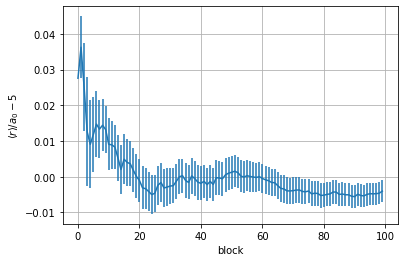

stima finale di <r>: 4.996 a_0
incertezza: 0.003 a_0

distante 1.3σ dal valore aspettato


In [9]:
r, err = np.loadtxt('../05/gauss2p_bm.out', usecols=(0,1), delimiter=" ", unpack=True)
x = np.arange(0, len(r))
plt.errorbar(x, r-5, err)
plt.xlabel("block")
plt.ylabel('$\\langle r \\rangle /a_0 -5$')
plt.grid()
plt.show()

print("stima finale di <r>: {:.4} a_0".format(r[-1]))
print("incertezza: {:.1} a_0".format(err[-1]))
print('\ndistante {:.1f}σ dal valore aspettato'.format(abs(r[-1]-5)/err[-1]))

Il risultato ottenuto è compatibile con quello calcolato analiticamenente.

## Visualizzazione dei punti campionati

Per entrambe le distribuzioni di probabilità campionate ho anche eseguito delle simulazioni salvando tutti i punti estratti. I risultati ottenuti sono i seguenti e mostrano il successo dell'algoritmo di Metropolis nel campionamento delle distribuzioni di probabilità scelte. I grafici successivi mostrano i punti ottenuti con distribuzione di probabilità uniforme come funzione di transizione, l'altra scelta non mostra differenze.

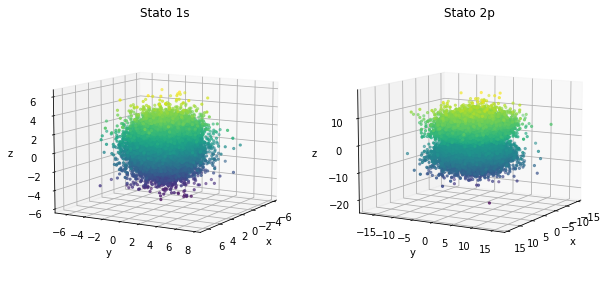

In [10]:
fig = plt.figure(figsize=[10,5])

x, y, z = np.loadtxt('../05/uni1s_points.out', usecols=(0,1,2), delimiter=" ", unpack=True)
ax1s = fig.add_subplot(1, 2, 1, projection='3d', label='1s')
ax1s.scatter(x, y, z, c=z, marker='.')
ax1s.set_xlabel('x')
ax1s.set_ylabel('y')
ax1s.set_zlabel('z')
ax1s.set_title('Stato 1s')
ax1s.view_init(10, 30)

x, y, z = np.loadtxt('../05/uni2p_points.out', usecols=(0,1,2), delimiter=" ", unpack=True)
ax2p = fig.add_subplot(1, 2, 2, projection='3d', label='2p')
ax2p.scatter(x, y, z, c=z, marker='.')
ax2p.set_xlabel('x')
ax2p.set_ylabel('y')
ax2p.set_zlabel('z')
ax2p.set_title('Stato 2p')
ax2p.view_init(10, 30)
plt.show()

## Conclusioni

In questa esercitazione è stato applicato con successo l'algoritmo di Metropolis per il campionamento delle distribuzioni di probabilità ottenute da funzioni d'onda.
Sono state presentate diverse scelte riguardanti alcuni parametri dell'algoritmo e sono state proposte soluzioni e metodi per affrontarle.
I risultati ottenuti sono infine apparsi compatibili con i valori ottenibili analiticamente. Non sono inoltre state riscontrate significative differenze tra i risultati ottenuti con le due diverse funzioni di transizione.